In [4]:
# from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
 
import tensorflow as tf
from tensorflow.python.platform import tf_logging as logging

import datetime
 
logging.set_verbosity(logging.INFO)
logging.log(logging.INFO, "Tensorflow version " + tf.__version__)

import warnings
warnings.filterwarnings('ignore')

INFO:tensorflow:Tensorflow version 1.10.0


In [5]:
def generate_time_series(datalen):
    freq1 = 0.2
    freq2 = 0.15
    noise = [np.random.random() * 0.1 for i in range(datalen)]
    x1 = np.sin(np.arange(0, datalen) * freq1) + noise
    x2 = np.sin(np.arange(0, datalen) * freq2) + noise
    x = x1 + x2
    return x.astype(np.float32)
 
 
DATA_SEQ_LEN = 24000
 
data = generate_time_series(DATA_SEQ_LEN)

In [6]:
data.shape

(24000,)

In [7]:
SEQLEN = 16  # unrolled sequence length
BATCHSIZE = 32
 
X = data
Y = np.roll(data, -1)

X_train, X_test = X[0:len(X)-4000], X[len(X)-4000:]
Y_train, Y_test = Y[0:len(Y)-4000], Y[len(Y)-4000:]

In [8]:
X_train = np.reshape(X_train, [-1, SEQLEN])
Y_train = np.reshape(Y_train, [-1, SEQLEN])

X_test = np.reshape(X_test, [-1, SEQLEN])
Y_test = np.reshape(Y_test, [-1, SEQLEN])

In [9]:
def train_dataset():
    dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
    dataset = dataset.repeat()
    dataset = dataset.shuffle(DATA_SEQ_LEN * 4 // SEQLEN)
    dataset = dataset.batch(BATCHSIZE)
    samples, labels = dataset.make_one_shot_iterator().get_next()
    return samples, labels
 
 
def eval_dataset():
    evaldataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test))
    evaldataset = evaldataset.repeat(1)
    evaldataset = evaldataset.batch(BATCHSIZE)
    samples, labels = evaldataset.make_one_shot_iterator().get_next()
    return samples, labels

In [10]:
RNN_CELLSIZE = 80
N_LAYERS = 2
DROPOUT_PKEEP = 0.7
 
def model_rnn_fn(features, labels, mode):
    
    X = tf.expand_dims(features, axis=2)
 
    batchsize = tf.shape(X)[0]
    seqlen = tf.shape(X)[1]
 
    cells = [tf.nn.rnn_cell.GRUCell(RNN_CELLSIZE) for _ in range(N_LAYERS)]
 
    cells[:-1] = [tf.nn.rnn_cell.DropoutWrapper(cell, output_keep_prob=DROPOUT_PKEEP) for cell in cells[:-1]]
    
    # a stacked RNN cell still works like an RNN cell
    cell = tf.nn.rnn_cell.MultiRNNCell(cells, state_is_tuple=False)

    # X[BATCHSIZE, SEQLEN, 1], Hin[BATCHSIZE, RNN_CELLSIZE*N_LAYERS]
    Yn, H = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

    Yn = tf.reshape(Yn, [batchsize * seqlen, RNN_CELLSIZE])
    Yr = tf.layers.dense(Yn, 1)  # Yr [BATCHSIZE*SEQLEN, 1]
    Yr = tf.reshape(Yr, [batchsize, seqlen, 1])  # Yr [BATCHSIZE, SEQLEN, 1]

    Yout = Yr[:, -1, :]  # Last output Yout [BATCHSIZE, 1]

    loss = train_op = None
    if mode != tf.estimator.ModeKeys.PREDICT:
        labels = tf.expand_dims(labels, axis=2)
        loss = tf.losses.mean_squared_error(Yr, labels)  # la  bels[BATCHSIZE, SEQLEN, 1]
        lr = 0.001
        optimizer = tf.train.AdamOptimizer(learning_rate=lr)

        train_op = tf.contrib.training.create_train_op(loss, optimizer)

    return tf.estimator.EstimatorSpec(
        mode=mode,
        predictions={"Yout": Yout},
        loss=loss,
        train_op=train_op
    )

In [11]:
training_config = tf.estimator.RunConfig(model_dir="./outputdir")
estimator = tf.estimator.Estimator(model_fn=model_rnn_fn, config=training_config)

INFO:tensorflow:Using config: {'_model_dir': './outputdir', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x00000178132DE5C0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [12]:
estimator.train(input_fn=train_dataset, steps=2000)

INFO:tensorflow:Calling model_fn.


NotFoundError: C:\Users\Lahiru Sampath\Anaconda3\envs\nn_all\lib\site-packages\tensorflow\contrib\coder\python\ops\_coder_ops.so not found

Month
1901-01-01    266.0
1901-02-01    145.9
1901-03-01    183.1
1901-04-01    119.3
1901-05-01    180.3
Name: Sales, dtype: float64


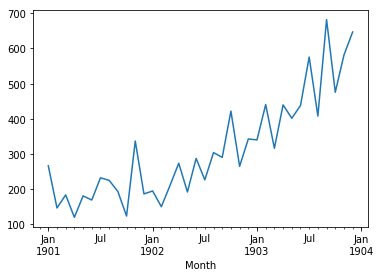

In [2]:
def parser(x):
    return pd.datetime.strptime('190'+x, '%Y-%m')
 
series = pd.read_csv('shampoo.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
print(series.head())
series.plot()
pyplot.show()

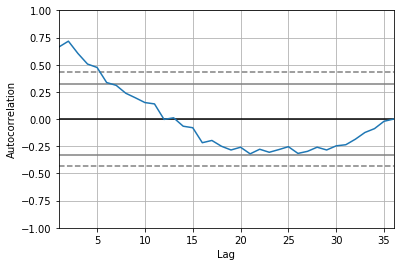

In [3]:
pd.plotting.autocorrelation_plot(series)
pyplot.show()

In [4]:
def parser(x):
	return pd.datetime.strptime('190'+x, '%Y-%m')

predicted=363.439806, expected=342.300000
predicted=326.025755, expected=339.700000
predicted=420.537739, expected=440.400000
predicted=369.662686, expected=315.900000
predicted=374.927744, expected=439.300000
predicted=351.699197, expected=401.300000
predicted=407.462276, expected=437.400000
predicted=424.063182, expected=575.500000
predicted=426.862887, expected=407.600000
predicted=396.397846, expected=682.000000
predicted=407.199283, expected=475.300000
predicted=437.602341, expected=581.300000
predicted=466.568806, expected=646.900000
Test MSE: 13392.148


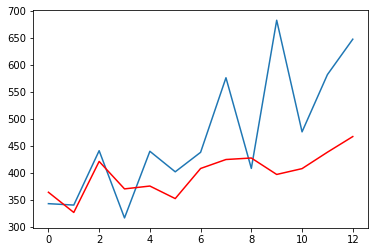

In [11]:
X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
	model = ARIMA(history, order=(4,1,2))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(yhat)
	print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()